# PREDICTION OF THE ENSO INDEX
- Regression problem
- Oceanography/Climate
- Pierre Tandeo (pierre.tandeo@imt-atlantique.fr), Ronan Fablet (ronan.fablet@imt-atlantique.fr)

## Data and aim

The database used in this project is coming from NOAA ERSST for Extended Reconstructed Sea Surface Temperature (more details here: https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v4). They correspond to monthly maps of SST anomalies (from a 1971-2000 climatology) in the global ocean. It takes into account in situ measurements (buoys, ships) and satellite observations (since the 70th). Data are available between 1854 and 2017.

![ENSO](https://tandeo.files.wordpress.com/2019/01/enso_nino_nina.png)

The goal is to predict the ENSO index calculated from averaged SST anomalies over the El Nino 3.4 region, 6 months ahead. Below, you will find an explanation of El Nino and La Nina.

## Evaluation and benchmark

You will use SST anomaly fields to predict ENSO index 6 month ahead using regression approaches. To evaluate and compare the results, we propose to use a cross validation, repeated 100 times on 70% of training and 30% of validation. The reference score is **RMSE=0.42**. Then, we propose to test the methodology on the prediction of the last 10 years and try to see if you are able to predict the last big El Nino event in 2009-2010 and 2015-2016.

## References
- http://journals.ametsoc.org/doi/pdf/10.1175/1520-0477%281997%29078%3C2771%3ATDOENO%3E2.0.CO%3B2 (for more information regarding the ENSO index and how to calculate it from SST)
- http://journals.ametsoc.org/doi/abs/10.1175/1520-0442(2001)013%3C3953:LLPOPS%3E2.0.CO;2 (reference paper on the prediction of ENSO using statistical approaches)
- https://drive.google.com/file/d/0B-oKhfYlOUQaZFRfRmMwSjREdUk/view?usp=sharing (for an overview of existing statistical methods to predict the ENSO index)

### Import libraries

First, we import the Python libraries we will use during this project. The main one are netCDF4 (to read netcdf files) and scikit-learn (for machine learning).

In [69]:
# install netcdf4 if necessary
#!pip install netcdf4

# import classical libraries
%matplotlib inline
%pylab inline

# import machine learning library
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from netCDF4 import Dataset
from datetime import date

# figure size
plt.rcParams['figure.figsize'] = (16, 9)

Populating the interactive namespace from numpy and matplotlib


### Import and plot data

Here, we import the full netcdf file of the 163 years of SST anomalies in the Equatorial Pacific. We will use "lon", "lat", "time" and "sst_ano" for the different variables. Note that you can select a subsample of the dataset, selecting the time period (i_good_time).

Text(0.5, 1.0, 'Example of global SST anomaly field')

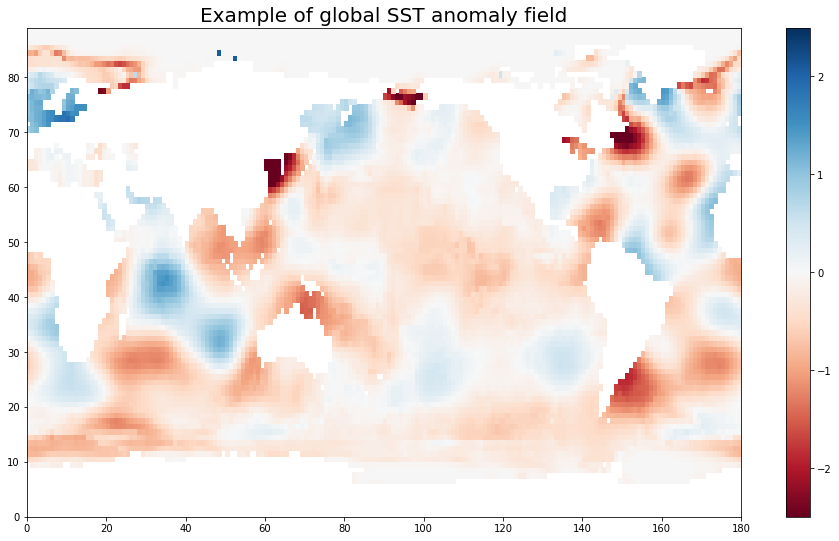

In [64]:
# load netcdf file
data_ERSST = Dataset("data_ERSST.nc")

# extract lon, lat, time, sst_ano
lon = data_ERSST.variables['X'][:]
lat = data_ERSST.variables['Y'][:]
time_tmp = data_ERSST.variables['T'][:]*30.417 + date(1960,1,1).toordinal()
sst_ano_tmp = data_ERSST.variables['anom'][:]
i_good_time = where((time_tmp>=date(1854,1,1).toordinal()) & (time_tmp<=date(2018,1,1).toordinal())) # select a specific period
time = time_tmp[i_good_time]
sst_ano = squeeze(sst_ano_tmp[i_good_time,0,:,:])

# plot a sample of data
pcolor(sst_ano[100,:,:],cmap='RdBu');clim([-2.5,2.5]);colorbar()
title('Example of global SST anomaly field', size=20)

### Compute the ENSO index

To compute the ENSO index, we average the SST anomalies in the Tropical Pacific (El Nino 3.4 region). The El Nino/La Nina threshold is $0.5^\circ$ Celsius. The plot displays the warm periods as red (El Nino) and cold periods (La Nina) as blue. To be precise, El Nino requires a period of consecutive three months with mean temperatures $0.5^\circ$ Celsius above the seasonal average.

latitudes: 
[-4. -2.  0.  2.  4.]
longitudes: 
[190. 192. 194. 196. 198. 200. 202. 204. 206. 208. 210. 212. 214. 216.
 218. 220. 222. 224. 226. 228. 230. 232. 234. 236. 238. 240.]


Text(0.5, 1.0, 'ENSO index')

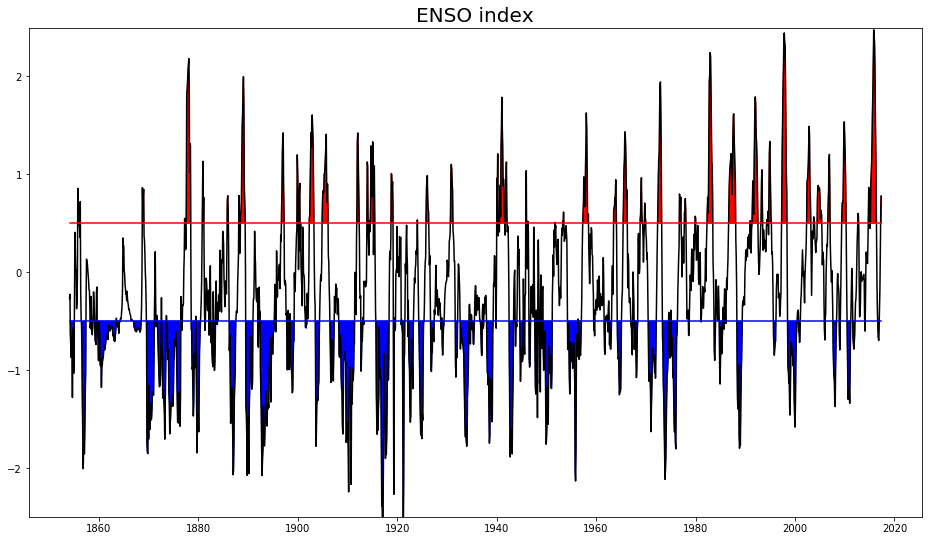

In [65]:
# ENSO region (El Nino 3.4 region)
print('latitudes: ');print(lat[42:47])
print('longitudes: ');print(lon[95:121])

# extract ENSO index
enso = mean(mean(sst_ano[:,42:47,95:121], axis=2), axis=1)

# plot ENSO index
plot_date(time, enso, '-k')
xrange = np.arange(0,len(enso))
y = enso
x_limits = [min(time), max(time)]
y_limits = [-2.5, 2.5]
el_nino_threshold = 0.5
plot(x_limits, [el_nino_threshold, el_nino_threshold], c='r')
plot(x_limits, [-el_nino_threshold, -el_nino_threshold], c='b')
fill_between(time, el_nino_threshold, y, color='red', where=y>=el_nino_threshold, interpolate=True)
fill_between(time, -el_nino_threshold, y, color='blue', where=y<=-el_nino_threshold)
ylim([-2.5,2.5])
title('ENSO index',size=20)

### Feature extraction

Here, we declare the input variable $X$ (map of SST anomalies in the El Nino 3.4 region at month $m$) and the response variable $y$ (ENSO index at month $m+6$). Note that other SST anomalies can be used (larger region, delayed times, etc...).

In [0]:
# regional SST anomalies (can be different than the El Nino 3.4 region)    
sst_ano_region = sst_ano[:,42:47,95:121]

# ENSO index (do not change that!)
enso = mean(mean(sst_ano[:,42:47,95:121], axis=2), axis=1)

# select times (SST anomalies at month m and ENSO index at month m+6)
time_steps, nb_lat, nb_lon = shape(sst_ano_region)
time_good_X = range(0,time_steps-5)
time_good_y = range(5,time_steps)

# generate X and y
X = reshape(sst_ano_region[time_good_X,:,:],(len(time_good_X),nb_lat*nb_lon))
y = enso[time_good_y]